# STAT 542 / CS 598: Homework 6
Fall 2019, by Edgar Pino

Due: Monday, Nov 11 by 11:59 PM Pacific Time

In [23]:
%matplotlib inline

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from cvxopt import matrix, solvers

# Question 1 [50 Points] Linearly Separable SVM using Quadratic Programming

In [25]:
np.random.seed(1)

In [26]:
COLOR_LABELS = ["darkorange","deepskyblue"]

In [27]:
N = 40
P = 2

In [28]:
xpos = np.random.normal(0, 1,(N,P))
xneg = np.random.normal(4, 1,(N,P))

In [29]:
x = np.concatenate((xpos, xneg), axis=0)
y = np.concatenate((np.ones((N,)), -np.ones((N,))), axis=0)

In [30]:
def plot_data(x, y):
    unique = np.unique(y)
    for li in range(len(unique)):
        items = x[y == unique[li]]
        label = 'Positive' if unique[li] == -1 else 'Negative'
        plt.scatter(items[:, 0], items[:, 1], c = COLOR_LABELS[li], label=label)
    plt.legend()

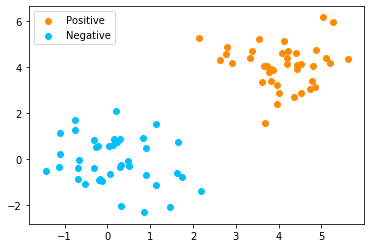

In [31]:
plot_data(x,y)

### Fit

In [32]:
def fit(x, y): 
    NUM = x.shape[0]
    DIM = x.shape[1]
    K = y[:, None] * x
    K = np.dot(K, K.T)
    P = matrix(K)
    q = matrix(-np.ones((NUM, 1)))
    G = matrix(-np.eye(NUM))
    h = matrix(np.zeros(NUM))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    
    solvers.options['show_progress'] = False
    
    return solvers.qp(P, q, G, h, A, b)

In [33]:
def plot_separator(ax, w, b):
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    x = np.arange(0, 6)
    ax.plot(x, x * slope + intercept, 'k-')

In [34]:
def plot_data_with_labels(x, y, ax):
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        label = 'Positive' if unique[li] == 1 else 'Negative'
        ax.scatter(x_sub[:, 0], x_sub[:, 1], c = COLOR_LABELS[li], label=label)

In [35]:
sol = fit(x, y)
alphas = np.array(sol['x'])

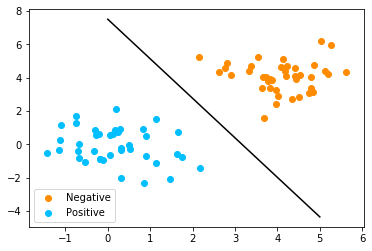

In [36]:
w = np.sum(alphas * y[:, None] * x, axis = 0)
cond = (alphas > 1e-4).reshape(-1)
b = y[cond] - np.dot(x[cond], w)
bias = b[0]

norm = np.linalg.norm(w)
w, bias = w / norm, bias / norm

fig, ax = plt.subplots()
plot_separator(ax, w, bias)
plot_data_with_labels(x, y, ax)

plt.legend()
plt.show()

In [1]:
# https://pythonprogramming.net/soft-margin-kernel-cvxopt-svm-machine-learning-tutorial/

# Question 2 [25 Points] Linearly Non-seperable SVM using Penalized Loss

In [37]:
from scipy.optimize import minimize

In [38]:
np.random.seed(1)

In [39]:
N = 100
P = 2

In [40]:
xpos = np.random.normal(0, 1,(N,P))
xneg = np.random.normal(1.5, 1,(N,P))

In [41]:
x = np.concatenate((xpos, xneg), axis=0)
y = np.concatenate((np.ones((N,)), -np.ones((N,))), axis=0)

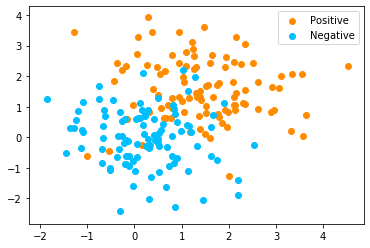

In [42]:
plot_data(x,y)

In [43]:
# https://houxianxu.github.io/2015/04/25/support-vector-machine/

In [44]:
def loss():
    pass